<h1 align="center" style="background-color:#616161;color:white">Linear Regression with RBF</h1>

<h3 style="background-color:#616161;color:white">0. Setup</h3>

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Input Parameters</div>

In [1]:
# Root path
#root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
root = "/home/badrul/git/EventPrediction" # BA, Linux

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Common Libraries</div>

In [2]:
# Core
import numpy as np
import pandas as pd
from IPython.core.debugger import Tracer    # Used for debugging
import logging

# File and database management
import csv
import os
import sys
import json
import sqlite3
from pathlib import Path

# Date/Time
import datetime
import time
#from datetime import timedelta # Deprecated

# Visualization
import matplotlib.pyplot as plt             # Quick
%matplotlib inline

# Misc
import random
from importlib import reload
#reload(cc)

#-------------- Custom Libs -----------------#
os.chdir(root)

# Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)

# Custom Libs
import coreCode as cc
import lastfmCode as fm

<div style="background-color:white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Page Specific Libraries</div>

In [3]:
# Data science (comment out if not needed)
#from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
from sklearn import metrics
from sklearn import preprocessing

<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Load settings</div>

In [4]:
settingsDict =  cc.loadSettings()
dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']
periodGranularity = int(settingsDict['periodGranularity'])

<h3 style="background-color:#616161;color:white">1. Load data</h3>

In [5]:
fieldList="t, UserID, HrsFrom5pm, isSun,isMon,isTue,isWed,isThu,isFri,isSat,t1,t2,t3,t4,t5,t10,t12hrs, t23_5hrs, t24hrs, t24_5hrs, t1wk,t2wks,t3wks,t4wks"
xTrain, yTrain, xTest, yTest = cc.getHiddenPeriodsData(dbPath,fieldList,oneHot=False,periodGranularity=periodGranularity)
xTest2, yTest2,testDf2 = cc.getHiddenUsersData(dbPath, fieldList,oneHot=False,firstNPerc=0.5,periodGranularity=periodGranularity)

Skipping user 73 as not enough periods (1882)
Skipping user 97 as not enough periods (0)


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Confirm dimensions</div>

In [6]:
np.shape(xTrain), np.shape( yTrain)

((3560116, 22), (3560116, 1))

In [7]:
np.shape(xTest), np.shape( yTest),np.shape(xTest2), np.shape( yTest2)

((220761, 22), (220761, 1), (217233, 22), (217233, 1))

<h3 style="background-color:#616161;color:white">3. Model Three: Logistic Regression with RBF Kernel</h3>

In [8]:
# Set parameters
learning_rate = 0.01
display_step = 2

batch_size=2000
    
numOfFeatures=np.shape(xTrain)[1] # 784 for MNIST
numOfClasses=1
    
# TF graph input
x = tf.placeholder("float", [None, numOfFeatures]) # mnist data image of shape 28*28=784
y = tf.placeholder("float", [None, numOfClasses]) # 0-9 digits recognition => 10 classes
prediction_grid = tf.placeholder(shape=[None, 1], dtype=tf.float32)   # Only needed for a 1d problem - see later on

# Create a model

# Set model weights
W = tf.Variable(tf.zeros([numOfFeatures, numOfClasses]))
#b = tf.Variable(tf.zeros([numOfClasses]))
# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))   # *****Should this be 20 , batch_size?*****

# Define RBF Kernel: https://stackoverflow.com/questions/37362258/creating-a-radial-basis-function-kernel-matrix-in-matlab
# Gaussian (RBF) training function
gamma = tf.constant(-50.0)
dist = tf.reshape(tf.reduce_sum(tf.square(x), 1), [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x, tf.transpose(x)))), tf.transpose(dist))
RBFKernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))


# ******This is the code for if you are using an input grid to test out lots of x values. Not going to use this for multi-dim
#rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1]) 
#sq_distPred = tf.add(tf.subtract(distPred, tf.multiply(2., tf.matmul(x, tf.transpose(prediction_grid)))), tf.transpose(rB))
# *****Instead we will use the same kernel as above. 

prediction_output = tf.matmul(tf.multiply(tf.transpose(x),b), RBFKernel)
prediction = tf.reshape(prediction_output-tf.reduce_mean(prediction_output),[-1,1])
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y)), tf.float32))

##### Compute cost function

first_term = tf.reduce_sum(b)   # sum all elements together
bsq = tf.matmul(tf.transpose(b), b)    # b^2
ysq = tf.matmul(y, tf.transpose(y))  # y^2
second_term = tf.reduce_sum(tf.multiply(RBFKernel, tf.multiply(bsq, ysq)))
cost_function = tf.negative(tf.subtract(first_term, second_term))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)
print('Ok')

Ok


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Train the model</div>

In [9]:
training_iteration = 5

# Launch the graph
sess = tf.Session()

# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init)

# Training cycle
for iteration in range(training_iteration):
    avg_cost = 0.
    total_batch = int(len(xTrain)/batch_size)

    # Loop over all batches
    for i in range(total_batch):
        batch_xs = xTrain[i*batch_size:(i*batch_size)+batch_size]
        batch_ys = yTrain[i*batch_size:(i*batch_size)+batch_size]                

        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost_function, feed_dict={x: batch_xs, y: batch_ys})/total_batch

    # Display logs per iteration step
    #if iteration % display_step == 0:
    print (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Iteration:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(avg_cost))

print (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Training completed!")


2017-08-05 22:46:45 Iteration: 0001 cost= -4576.976590343
2017-08-05 22:57:03 Iteration: 0002 cost= -5344.241996851
2017-08-05 23:06:07 Iteration: 0003 cost= -5346.559618866
2017-08-05 23:15:03 Iteration: 0004 cost= -5346.610932014
2017-08-05 23:24:10 Iteration: 0005 cost= -5346.612905164
2017-08-05 23:24:10 Training completed!


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Test Hidden Periods</div>

In [14]:
predictions=[]
# Testing cycle
total_batch = int(len(xTest)/batch_size)

if np.mod(len(xTest),batch_size) != 0:
    # tf requires consistent inputs so need to pad
    rowsToPad=batch_size-np.mod(len(xTest),batch_size)
    padRows=np.zeros([rowsToPad,xTest.shape[1]])
    xTest = np.append(xTest,padRows,axis=0)
    padRows=np.zeros([rowsToPad,yTest.shape[1]])
    yTest = np.append(yTest,padRows,axis=0)
    total_batch += 1
 
# Loop over all batches
for i in range(total_batch):
    batch_xs = xTest[i*batch_size:(i*batch_size)+batch_size]
    batch_ys = yTest[i*batch_size:(i*batch_size)+batch_size]                

    p=1*sess.run(tf.greater_equal(prediction, 0.5),feed_dict={x: batch_xs,y: batch_ys})
    predictions= np.append(predictions,p)

n=len(xTest)-rowsToPad
xTest=xTest[0:n]
yTest=yTest[0:n]
predictions=predictions[0:n]

print(metrics.classification_report(yTest,predictions))
#print(metrics.confusion_matrix(yTest,predictions))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset")
print ("0.0 Did not play music. 1.0 = Played muisc\r")

             precision    recall  f1-score   support

        0.0       0.92      0.91      0.91    202306
        1.0       0.08      0.09      0.08     18455

avg / total       0.85      0.84      0.84    220761

* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset
0.0 Did not play music. 1.0 = Played muisc


<div style="background-color:#white; color:#008000; font-family: 'Courier New, Monospace;font-weight: bold">Test Hidden Users</div>

In [15]:
predictions=[]
total_batch = int(len(xTest2)/batch_size)

if np.mod(len(xTest2),batch_size) != 0:
    # tf requires consistent inputs so need to pad
    rowsToPad=batch_size-np.mod(len(xTest2),batch_size)
    padRows=np.zeros([rowsToPad,xTest2.shape[1]])
    xTest2 = np.append(xTest2,padRows,axis=0)
    padRows=np.zeros([rowsToPad,yTest2.shape[1]])
    yTest2 = np.append(yTest2,padRows,axis=0)
    total_batch += 1
 
# Loop over all batches
for i in range(total_batch):
    batch_xs = xTest2[i*batch_size:(i*batch_size)+batch_size]
    batch_ys = yTest2[i*batch_size:(i*batch_size)+batch_size]                

    p=1*sess.run(tf.greater_equal(prediction, 0.5),feed_dict={x: batch_xs,y: batch_ys})
    predictions= np.append(predictions,p)

n=len(xTest2)-rowsToPad
xTest2=xTest2[0:n]
yTest2=yTest2[0:n]
predictions=predictions[0:n]


print(metrics.classification_report(yTest2,predictions))
print("* Precision = labelled as x / how many were actually x in the ones that were labelled")
print("* Recall = labelled as x / how many were actually x in the dataset\r")
print ("0.0 Did not play music. 1.0 = Played muisc\r")

#print(metrics.confusion_matrix(yTest2,predictions))
#print ("\rConfusion matrix:")

             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90    192600
        1.0       0.09      0.06      0.07     24633

avg / total       0.79      0.82      0.81    217233

* Precision = labelled as x / how many were actually x in the ones that were labelled
* Recall = labelled as x / how many were actually x in the dataset
0.0 Did not play music. 1.0 = Played muisc


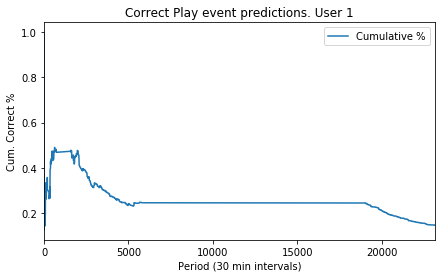

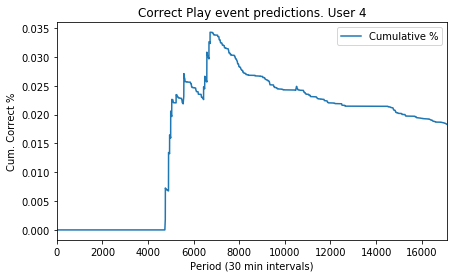

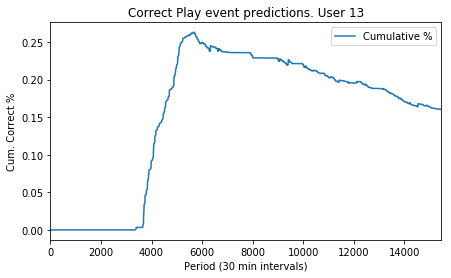

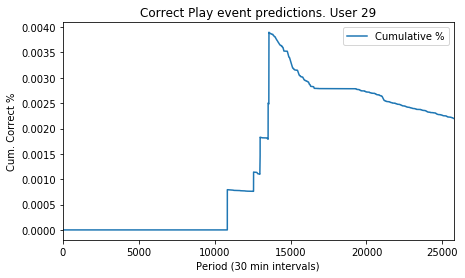

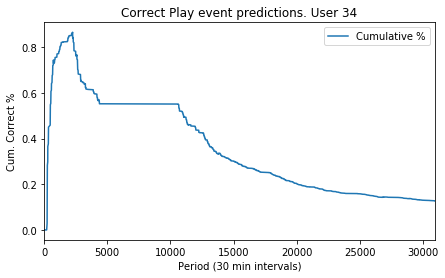

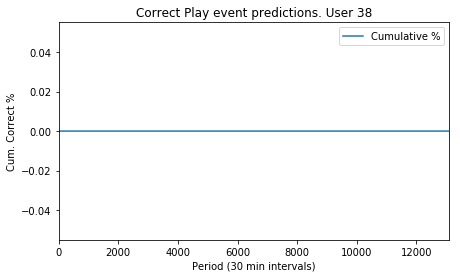

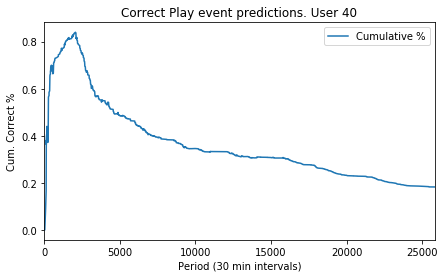

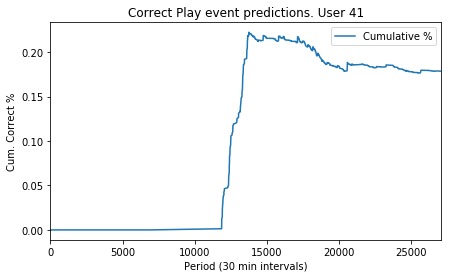

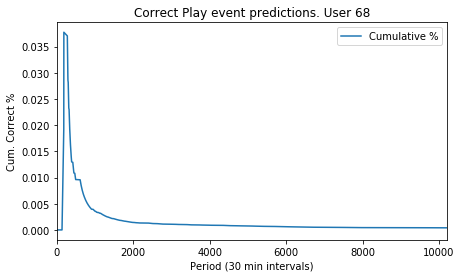

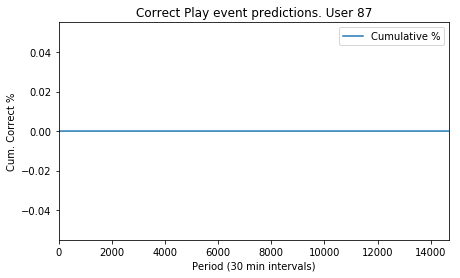

In [16]:
df=pd.DataFrame({'UserID': testDf2.UserID.values, 'Actual':yTest2.reshape(-1,), 'Predicted':predictions.tolist()})
df['Period'] = df.index
df['Correct'] = (df['Actual'] == df['Predicted'])*1
df1 = df[df.Actual==1]
df1.set_index(['UserID','Period'],inplace=True)

df1= df1.assign(**{'Cum Correct': df1.groupby(level=0)["Correct"].cumsum()})
df1= df1.assign(**{'Cum Total': df1.groupby(level=0)["Actual"].cumsum()})
df1= df1.assign(**{'Cumulative %': df1.groupby(level=0)["Correct"].cumsum()/df1.groupby(level=0)["Actual"].cumsum()})

for u in df1.index.get_level_values(0).unique():
    tmp=df1.loc[u].head(5000)
    ax=tmp.plot(y='Cumulative %',title='Correct Play event predictions. User {}'.format(u),figsize=(7,4),x=(tmp.index.values - min(tmp.index.values)))
    ax.set_ylabel("Cum. Correct %")
    ax.set_xlabel("Period (30 min intervals)")

In [17]:
df[df.Predicted == 1]

,Actual,Predicted,UserID,Period,Correct
0,0.0,1.0,1,0,0
9,0.0,1.0,1,9,0
10,0.0,1.0,1,10,0
11,0.0,1.0,1,11,0
12,0.0,1.0,1,12,0
13,0.0,1.0,1,13,0
14,0.0,1.0,1,14,0
15,0.0,1.0,1,15,0
16,0.0,1.0,1,16,0
17,0.0,1.0,1,17,0


<h3 style="background-color:#616161;color:white">4. My notes - please ignore</h3>

Source: 
https://github.com/nfmcclure/tensorflow_cookbook/blob/master/04_Support_Vector_Machines/04_Working_with_Kernels/04_svm_kernels.ipynb

https://github.com/nfmcclure/tensorflow_cookbook/blob/master/04_Support_Vector_Machines/04_Working_with_Kernels/04_svm_kernels.py


Good resouorces: 
* http://mccormickml.com/2014/02/26/kernel-regression/
* http://www.cc.gatech.edu/~isbell/tutorials/rbf-intro.pdf
* http://perso.telecom-paristech.fr/~clemenco/Projets_ENPC_files/kernel-log-regression-svm-boosting.pdf

Notes:
$$P(y_t == 1) = b + \sum_i w_i \int RBF(t'; t-t_i, sigma_I) dt$$

$$f(x)=b+
\sum^N_{i=1}w_iRBF(x,x_i)$$

Where $w_i$ are the parameters of the linear regression and $t_i$,sigma_i are the parameters of the kernel (which can be optimised jointly or via CV). Then, for example, you could have t_i = [1 hour, 1 day, 1 week] and sigma_d = [10min, 1hour, 12hours]. That way it would give a real-valued score to all tracks played around 1 hour +-10min ago, around 1 day +-1hour ago, etc.

This is a good reference: http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf
$$x = test data$$
$$x_i = train data$$
$$rA = x_i^2$$
$$rB=x^2$$
$$\gamma ||(x_i^2 -(x_i  x)^2 + x^2)||$$

Note following how this is 'the exact same thing as above' or how it relates to the RBF formulas I see in the pdf ref



The whole trick is based on the fact that you want to compute matrix $K_ij = K(x_i, x_j) = f(||x_i - x_j||^2)$ in an efficient manner. Matrix computations are based on dot products, thus multiplications, not on norm of a difference. If you do not want to use loops (and in languages like matlab or R you do not want to) you have to figure out how to express this $||x_i - x_j||^2$ using matrix operations, thus:

$$||x_i - x_j||^2 = <x_i - x_j, x_i - x_j> 
                = <x_i, x_i> - <x_i, x_j> - <x_j, x_i> + <x_j, x_j>
                = ||x_i||^2 - 2<x_i, x_j> + ||x_j||^2$$

and this is exactly what is implemented

First they take square of your data, as $||x_i||^2 = \sum _a x_i_a^2$

nms = $sum(X'.^2)$;

next they use multiplication with vector of ones to compute the sum opertion getting

nms'*ones(1,n)

which is vector of ||x_i||^2's, and analogously vector of ||x_j||^2's is

ones(n,1)*nms

and finally they compose using decomposition I wrote before, thus

-nms'*ones(1,n) -ones(n,1)*nms + 2*X*X')

is just a matrix A_ij = - ||x_i - x_j ||^2

In your case, you want to have division by 2sigma^2, thus just put it under the exp, after taking previous arugment in brackets, like

Ks = exp(-(nms'*ones(1,n) -ones(n,1)*nms + 2*X*X')/(2*sigma^2));

